# Update Perchwell Plot Shapes
This notebook will prototype the steps needed to update Perchwell's NYC Plot shapes based on the shapes in MAP-PLUTO.

In [65]:
import pandas as pd
import sqlalchemy as db
import numpy as np
import geopandas as gpd
import json

from sqlalchemy import create_engine, text
from shapely.geometry import shape, MultiPolygon, Polygon
from sqlalchemy.orm import sessionmaker
from datetime import datetime

from data.library.pull_PW_data import pull_data

import pickle as pkl

from tqdm.notebook import tqdm

In [3]:
try:
    with open('data/buildings_final2.pkl', 'rb') as f:
        preso_gdf = pkl.load(f)
    print(preso_gdf.shape)
except FileNotFoundError:
    # downloading PW buildings table
    with open('pw_query.sql', 'r') as query_file:
        query_string = query_file.read()
        
    preso_gdf = pull_data(query_string)
print('done getting PW data')
preso_gdf = preso_gdf[preso_gdf.geometry_json.notnull()]
# Transform normal df to geopandas df
preso_gdf = gpd.GeoDataFrame(preso_gdf)
# Transform geojson to shapes
preso_gdf['geometry'] = [shape(json.loads(x)) for x in preso_gdf['geometry_json']]
# Set geometry for geodf
preso_gdf = preso_gdf.set_geometry('geometry')

preso_gdf.set_crs(crs="EPSG:4326", inplace=True)

(749222, 105)
done getting PW data


,id,city,state,zip,google_map_params,building_bike_storage,building_doorman,building_elevator,building_gym,building_laundry,...,num_mlsli,last_mlsli_listing,building_id,num_other_listings,last_listing,building_id,num_acris,last_acris_created,last_acris_sale,geometry_json
0,18,New York,NY,10038,None,None,None,None,None,None,...,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,None,"{""type"":""MultiPolygon"",""coordinates"":[[[[-74.0..."
1,55,New York,NY,10004,None,None,None,None,None,None,...,NaN,NaT,NaN,NaN,NaT,55.0,1.0,2018-03-20 01:38:46.073978,2016-04-22,"{""type"":""MultiPolygon"",""coordinates"":[[[[-74.0..."
2,79,New York,NY,10005,None,None,None,None,None,None,...,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,None,"{""type"":""MultiPolygon"",""coordinates"":[[[[-74.0..."
3,95,New York,NY,10005,,None,True,True,False,True,...,8.0,2022-06-03 22:45:22.709267,95.0,83.0,2023-03-22 17:08:28.306365,95.0,139.0,2023-05-17 16:01:42.366600,2023-05-08,"{""type"":""MultiPolygon"",""coordinates"":[[[[-74.0..."
4,108,New York,NY,10004,None,None,None,None,None,None,...,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT,None,"{""type"":""MultiPolygon"",""coordinates"":[[[[-74.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749213,4003393,Queens,NY,11360,None,None,None,None,None,None,...,NaN,NaT,4003393.0,1.0,2022-12-15 20:48:27.320533,4003393.0,1.0,2022-09-07 16:17:03.204651,2022-08-26,"{""type"":""MultiPolygon"",""coordinates"":[[[[-73.7..."
749214,5108857,Queens,NY,11433,None,None,None,None,None,None,...,NaN,NaT,5108857.0,3.0,2023-04-11 02:57:02.561357,5108857.0,1.0,2022-10-26 16:15:13.985049,2022-10-14,"{""type"":""MultiPolygon"",""coordinates"":[[[[-73.7..."
749215,5108859,Queens,NY,11435,None,None,None,None,None,None,...,NaN,NaT,5108859.0,3.0,2023-04-11 02:57:08.314030,5108859.0,1.0,2022-11-05 16:26:38.637013,2022-10-10,"{""type"":""MultiPolygon"",""coordinates"":[[[[-73.8..."
749216,5108864,Bronx,NY,10465,None,None,None,None,None,None,...,NaN,NaT,NaN,NaN,NaT,5108864.0,1.0,2022-11-23 17:04:54.402586,2022-11-11,"{""type"":""MultiPolygon"",""coordinates"":[[[[-73.8..."


In [4]:
update_df = pd.read_csv('data/update_df.csv')
update_df.groupby('field_name')['id'].nunique()

/var/folders/_3/v349phgn4ljd3jkf3ll9p2cm0000gp/T/ipykernel_69259/547334704.py:1: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  update_df = pd.read_csv('data/update_df.csv')


field_name
building_area      27564
building_class     31948
building_depth     15464
building_front     11180
geometry_x        730063
landmark_x          1261
lot_area          390865
lot_depth           4288
lot_front           6750
num_stories        19526
num_units          14903
year_built         19026
zip                 2779
Name: id, dtype: int64

In [5]:
def update_geometries(building_id):
    try:
        new_value = update_df[(update_df['field_name'] == 'geometry_x') & (update_df['id'] == building_id)]['new_value']
        return new_value.item()
    except ValueError:
        new_value = preso_gdf[preso_gdf['id'] == building_id]['geometry']
        return new_value.item()

In [6]:
try:
    with open('data/update_geos.pkl', 'rb') as f:
        update_geos = pkl.load(f)
except FileNotFoundError:
    update_geos = [update_geometries(x) for x in tqdm(preso_gdf['id'])]
    with open('data/update_geos.pkl', 'wb') as f:
        pkl.dump(update_geos, f)
preso_gdf['geometry'] = update_geos

/Users/arnavmalhotra/anaconda3/envs/pw/lib/python3.10/site-packages/geopandas/geodataframe.py:1537: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


In [7]:
updated_ids = set(update_df[update_df['field_name'] == 'geometry_x']['id'])
preso_gdf['updated'] = [1 if x in set(updated_ids) else 0 for x in tqdm(preso_gdf['id'])]
len(preso_gdf[preso_gdf.updated == 0])

  0%|          | 0/744425 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [8]:
def pw_to_gdf(preso):
    preso_gdf = gpd.GeoDataFrame(preso[preso.geometry_json.notnull()])
    preso_gdf['geometry'] = [shape(json.loads(x)) for x in preso_gdf['geometry_json']]    
    preso_gdf = preso_gdf.set_geometry('geometry')
    preso_gdf.set_crs(crs="EPSG:4326", inplace=True)
    preso_gdf['num_rls'].fillna(0, inplace=True)
    preso_gdf['num_mlsli'].fillna(0, inplace=True)
    preso_gdf['num_other_listings'].fillna(0, inplace=True)
    preso_gdf['num_acris'].fillna(0, inplace=True)
    return preso_gdf

In [9]:
preso_gdf = pw_to_gdf(preso_gdf)

In [12]:
preso_gdf['zip'] = pd.to_numeric(preso_gdf['zip'], 'coerce')
preso_gdf['source_id'] = pd.to_numeric(preso_gdf['source_id'], 'coerce')
#preso_gdf[['id', 'source_id', 'display_address', 'zip', 'updated', 'geometry']].to_file('data/preso_updated_geometries')

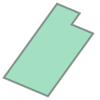

In [13]:
update_geometries(733)

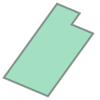

In [14]:
preso_gdf[preso_gdf['id'] == 733]['geometry'].item()

In [15]:
update_df[update_df['id'] == 733]

,Unnamed: 0,id,field_name,old_value,new_value,in_search


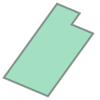

In [16]:
preso_gdf[preso_gdf['id'] == 733]['geometry'].item()

In [17]:
with open('data/update_geos.pkl', 'wb') as f:
    pkl.dump(update_geos, f)

In [18]:
# building_type
# building_area
# year_built
# num_stories
# building_class
# num_units

In [19]:
update_df.head()

,Unnamed: 0,id,field_name,old_value,new_value,in_search
0,0,538,zip,10005.0,10038.0,True
1,1,1757,zip,10038.0,10007.0,False
2,2,5051,zip,10001.0,10123.0,True
3,3,10005,zip,10020.0,10036.0,True
4,4,11722,zip,10007.0,10038.0,False


In [20]:
set(update_df['field_name'])

{'building_area',
 'building_class',
 'building_depth',
 'building_front',
 'geometry_x',
 'landmark_x',
 'lot_area',
 'lot_depth',
 'lot_front',
 'num_stories',
 'num_units',
 'year_built',
 'zip'}

In [21]:
updates_mapped = update_df.groupby(['field_name', 'old_value', 'new_value'])['id'].nunique()
updates_mapped.index

MultiIndex([('building_area',   '0.0',      '1'),
            ('building_area',   '0.0',    '100'),
            ('building_area',   '0.0',   '1000'),
            ('building_area',   '0.0',  '10012'),
            ('building_area',   '0.0',  '10023'),
            ('building_area',   '0.0', '100279'),
            ('building_area',   '0.0',  '10029'),
            ('building_area',   '0.0',  '10030'),
            ('building_area',   '0.0',  '10051'),
            ('building_area',   '0.0',   '1006'),
            ...
            (          'zip', '11215',  '11215'),
            (          'zip', '11219',  '11219'),
            (          'zip', '11220',  '11220'),
            (          'zip', '11221',  '11221'),
            (          'zip', '11222',  '11222'),
            (          'zip', '11225',  '11225'),
            (          'zip', '11230',  '11230'),
            (          'zip', '11231',  '11231'),
            (          'zip', '11233',  '11233'),
            (          'zip', '112

In [22]:
updates_mapped.drop('geometry_x', level=0, axis=0, inplace=True)
updates_mapped.to_csv('data/updates_mapping.csv')

In [ ]:
update_df.groupby(['field_name', 'old_value'])['id'].nunique().drop('geometry_x', level=0, axis=0).to_csv('data/updated_old_values.csv')

In [23]:
update_df.head()

,Unnamed: 0,id,field_name,old_value,new_value,in_search
0,0,538,zip,10005.0,10038.0,True
1,1,1757,zip,10038.0,10007.0,False
2,2,5051,zip,10001.0,10123.0,True
3,3,10005,zip,10020.0,10036.0,True
4,4,11722,zip,10007.0,10038.0,False


In [24]:
update_df = update_df[update_df['field_name'].isin(['building_area','building_class','building_depth','building_front','landmark_x','lot_depth','lot_front','num_stories','num_units','year_built'])]

In [25]:
res_ids = set(preso_gdf[(preso_gdf['building_class'].str[0].isin(['A', 'R', 'B', 'C', 'D', 'L', 'S']))]['id'])

In [26]:
update_class = update_df[update_df['field_name'] == 'building_class']

In [27]:
resbuildings = set(update_class[(update_class['old_value'].str[0].isin(['A', 'R', 'B', 'C', 'D', 'L', 'S'])) | (update_class['new_value'].str[0].isin(['A', 'R', 'B', 'C', 'D', 'L', 'S']))]['id'])

In [28]:
len(set(update_df[(update_df['id'].isin(resbuildings)) | (update_df['id'].isin(res_ids))]['id']))

54019

In [29]:
len(resbuildings)

21262

In [30]:
preso_resbuildings = preso_gdf[preso_gdf['id'].isin(set(update_df[(update_df['id'].isin(resbuildings)) | (update_df['id'].isin(res_ids))]['id']))]
preso_resbuildings.drop(columns=['created_at',
                            'updated_at',
                            'new_dev_start_date',
                            'new_dev_end_date',
                            'land_lease_expiration',
                            'last_rls_listing',
                            'last_mlsli_listing',
                            'last_listing',
                            'last_acris_created'], inplace=True)
preso_resbuildings = preso_resbuildings[preso_resbuildings['source_id'].astype(str).str.startswith('1')]
preso_resbuildings['source_id'] = pd.to_numeric(preso_resbuildings['source_id'], 'coerce')
preso_resbuildings[['id', 'geometry', 'display_address', 'source_id']].to_file('data/preso_update_resbuildings_mn')

/var/folders/_3/v349phgn4ljd3jkf3ll9p2cm0000gp/T/ipykernel_69259/3776978456.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  preso_resbuildings.drop(columns=['created_at',
/var/folders/_3/v349phgn4ljd3jkf3ll9p2cm0000gp/T/ipykernel_69259/3776978456.py:13: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  preso_resbuildings[['id', 'geometry', 'display_address', 'source_id']].to_file('data/preso_update_resbuildings_mn')


In [31]:
preso_resbuildings

,id,city,state,zip,google_map_params,building_bike_storage,building_doorman,building_elevator,building_gym,building_laundry,...,building_id,num_rls,building_id,num_mlsli,building_id,num_other_listings,building_id,num_acris,last_acris_sale,geometry_json
10,199,New York,NY,10012.0,,None,None,None,None,None,...,199.0,154.0,NaN,0.0,199.0,17.0,199.0,67.0,2023-05-30,"{""type"":""MultiPolygon"",""coordinates"":[[[[-73.9..."
13,257,New York,NY,10016.0,None,None,None,None,None,None,...,257.0,10.0,NaN,0.0,NaN,0.0,NaN,0.0,None,"{""type"":""MultiPolygon"",""coordinates"":[[[[-73.9..."
18,290,New York,NY,10011.0,None,None,None,None,None,None,...,290.0,5.0,NaN,0.0,290.0,3.0,290.0,2.0,2021-10-08,"{""type"":""MultiPolygon"",""coordinates"":[[[[-73.9..."
20,313,New York,NY,10013.0,None,False,False,True,False,False,...,313.0,46.0,NaN,0.0,313.0,10.0,313.0,28.0,2023-02-16,"{""type"":""MultiPolygon"",""coordinates"":[[[[-74.0..."
31,519,New York,NY,10001.0,None,None,None,None,None,None,...,NaN,0.0,NaN,0.0,519.0,1.0,519.0,2.0,2016-04-29,"{""type"":""MultiPolygon"",""coordinates"":[[[[-73.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
742984,661041,New York,NY,10016.0,None,None,None,None,None,None,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,None,"{""type"":""MultiPolygon"",""coordinates"":[[[[-73.9..."
742985,661075,New York,NY,10012.0,None,None,None,None,None,None,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,None,"{""type"":""MultiPolygon"",""coordinates"":[[[[-74.0..."
742991,661230,New York,NY,10017.0,None,None,None,None,None,None,...,NaN,0.0,NaN,0.0,NaN,0.0,NaN,0.0,None,"{""type"":""MultiPolygon"",""coordinates"":[[[[-73.9..."
747929,816529,New York,NY,10011.0,None,None,None,None,None,None,...,816529.0,1.0,NaN,0.0,816529.0,2.0,816529.0,2.0,2016-06-17,"{""type"":""MultiPolygon"",""coordinates"":[[[[-73.9..."


In [32]:
preso_resbuildings.shape

(10650, 96)

In [33]:
def get_pluto(pluto_fpath, shp_fpath):
    print('loading pluto_gdf')
    try:
        with open('data/gdf.pkl', 'rb') as f:
            pluto_gdf = pkl.load(f)
    except FileNotFoundError:
        pluto_gdf = gpd.read_file(shp_fpath)
        pluto_gdf.to_crs('epsg:4326', inplace=True)
    print('loading pluto files')
    if pluto_fpath:
        pluto = pd.read_csv(pluto_fpath)
        pluto = pluto[pluto['bbl'].isin(pluto_gdf['BBL'].to_list())]
    else:
        pluto = None
    return pluto, pluto_gdf

pluto, pluto_gdf = get_pluto(None, 'data/nyc_mappluto_23v1_1_shp/MapPLUTO.shp')

loading pluto_gdf
loading pluto files


In [34]:
preso_gdf['source_id'] = pd.to_numeric(preso_gdf['source_id'], 'coerce')
matched_buildings = preso_gdf.merge(pluto_gdf, how='inner', left_on='source_id', right_on='BBL')
matched_buildings = matched_buildings[matched_buildings['id'].isin(preso_resbuildings['id']) & matched_buildings['Borough'] == '1']
matched_buildings['id'].nunique()

0

In [35]:
preso_gdf[preso_gdf['id'] == 37528]

,id,city,state,zip,google_map_params,building_bike_storage,building_doorman,building_elevator,building_gym,building_laundry,...,num_mlsli,last_mlsli_listing,building_id,num_other_listings,last_listing,building_id,num_acris,last_acris_created,last_acris_sale,geometry_json
49018,37528,New York,NY,10011.0,None,False,True,True,False,False,...,0.0,NaT,37528.0,76.0,2022-08-30 08:56:17.812869,37528.0,115.0,2023-06-14 16:20:55.744758,2023-06-08,"{""type"":""MultiPolygon"",""coordinates"":[[[[-73.9..."


In [36]:
preso_resbuildings[preso_resbuildings['id'] == '37528']

,id,city,state,zip,google_map_params,building_bike_storage,building_doorman,building_elevator,building_gym,building_laundry,...,building_id,num_rls,building_id,num_mlsli,building_id,num_other_listings,building_id,num_acris,last_acris_sale,geometry_json


In [39]:
update_df[update_df['id'].isin(preso_resbuildings['id'])].groupby('field_name')['id'].nunique()

field_name
building_area     2047
building_class    2891
building_depth    1037
building_front     850
landmark_x         384
lot_depth          396
lot_front          536
num_stories        593
num_units         2066
year_built        6523
Name: id, dtype: int64

In [48]:
preso_gdf[preso_gdf['id'] == 11626]['source_id'].item()

1000160200.0

In [45]:
matched_buildings[matched_buildings['id'] == 11626]

,id,city,state,zip,google_map_params,building_bike_storage,building_doorman,building_elevator,building_gym,building_laundry,...,FIRM07_FLA,PFIRM15_FL,Version,DCPEdited,Latitude,Longitude,Notes,Shape_Leng,Shape_Area,geometry_y


In [49]:
update_df[update_df['id'] == 1647]

,Unnamed: 0,id,field_name,old_value,new_value,in_search
458114,458114,1647,building_class,D1,R4,True
516652,516652,1647,building_area,40665.0,39784,True


In [59]:
pluto_gdf['Address'].fillna('na', inplace=True)
pluto_gdf[pluto_gdf.Address.str.contains('12 WARREN')][['YearBuilt', 'Address', 'YearAlter1', 'YearAlter2']]

,YearBuilt,Address,YearAlter1,YearAlter2
131,2000,212 WARREN STREET,0,0
1288,1900,12 WARREN STREET,0,0
187761,1975,112 WARREN STREET,0,0
354037,1878,12 WARREN PLACE,0,0
359088,1899,312 WARREN STREET,0,0
479368,1910,40-12 WARREN STREET,0,0
622304,1930,37-12 WARREN STREET,0,0
624930,1901,41-12 WARREN STREET,0,0


In [60]:
preso_gdf[preso_gdf['id'] == 1647]['year_built']

111    2016.0
Name: year_built, dtype: float64

In [64]:
preso_gdf[preso_gdf['id'] == 146][c]

,num_stories,num_units,num_rls,num_mlsli,num_other_listings,num_acris
46692,1.0,0.0,0.0,0.0,0.0,0.0


In [62]:
c = [c for c in preso_gdf.columns if 'num' in c]

In [63]:
c

['num_stories',
 'num_units',
 'num_rls',
 'num_mlsli',
 'num_other_listings',
 'num_acris']

In [79]:
ids_to_check = [146,
146,
315,
380,
10910,
12665,
612,
662,
679,
661028,
27864,
661146,
679,
661028,
27864,
661146,
679,
661028,
679,
661028,
735,
1337,
28502,
1204,
6487,
1204,
6487,
1931,
2079,
2346,
2487,
3299,
5867,
8089,
9958,
11937,
15134,
3419,
3565,
10835,
3972,
4382,
10398,
5016,
5829,
5395,
39603,
5427,
10133,
5450,
661088,
13052,
27746,
28071,
5450,
661088,
5450,
661088,
13052,
27746,
28071,
5450,
661088,
5710,
5713,
5822,
6072,
7323,
11565,
6314,
6345,
6433,
38304,
6345,
6433,
38304,
6433,
7148,
7856,
7856,
8089,
8703,
9955,
10398,
10599,
10599,
10858,
11393,
11794,
11925,
12078,
12187,
12237,
13149,
13922,
13922,
13922,
14250,
14250,
15301,
20193,
23563,
26392,
32510,
33592,
36192,
40664,
15774,
15962,
15962,
15962,
15962,
17077,
18826,
23632,
26179,
36274,
42034,
17650,
17689,
17775,
661213,
17775,
661213,
17775,
661213,
17775,
661213,
17775,
661213,
17775,
661213,
17822,
20023,
25133,
32127,
17822,
20023,
18676,
19729,
26094,
18676,
26094,
18968,
19282,
28913,
39854,
19435,
31921,
37368,
19516,
19916,
23796,
30186,
38944,
20057,
32374,
20468,
863572,
21039,
28611,
34485,
21041,
41071,
21203,
21236,
21511,
21861,
22094,
22602,
41212,
22602,
22602,
41212,
22661,
26250,
23122,
33912,
23632,
24164,
30313,
39836,
24340,
25151,
36358,
25151,
25151,
36358,
25575,
40677,
42156,
25803,
661212,
25803,
661212,
25848,
25985,
36381,
37448,
41398,
26131,
26325,
36506,
40222,
27790,
28086,
30303,
28476,
35533,
28502,
28891,
28965,
29201,
31921,
31970,
33273,
33273,
33349,
34309,
34309,
35130,
41370,
35434,
35942,
36358,
36865,
37072,
38304,
38980,
39251,
40802,
41071,
41081,
41212,
42192,
42624,
42727,
637606,
637618,
637648,
637726,
637726,
679,
661028,
27864,
661146]

In [78]:
c += ['id']
c

['num_stories',
 'num_units',
 'num_rls',
 'num_mlsli',
 'num_other_listings',
 'num_acris',
 'id']

In [80]:
preso_gdf[preso_gdf['id'].isin(ids_to_check)][c].to_csv('data/manual_check_hide.csv')

In [81]:
preso_gdf[preso_gdf['id'] == 146][c]

,num_stories,num_units,num_rls,num_mlsli,num_other_listings,num_acris,id
46692,1.0,0.0,0.0,0.0,0.0,0.0,146


In [82]:
ids_to_check = [3498,
8732,
5213,
39248,
39248,
39248,
5850,
13669,
14270,
14270,
14270,
14270,
14270,
14270,
14270,
14270,
37019,
37019,
37019,
37019,
28558,
28558,
28558,
36843,
36843,
429,
429,
13601,
11259,
9512,
994,
8549,
8549,
8549,
8549,
8549,
8549,
11030,
13554,
13554,
28513,
16187,
16187,
10347,
10347,
677,
677,
6847,
6847,
6442,
6442,
6442,
6442,
6442,
6442,
6442,
3739,
3739,
3739,
3739,
3739,
3739,
3739,
27462,
160,
7840,
2299,
2299,
2299,
6639,
27451,
27451,
27451,
36932,
36932,
36932,
19142,
9553,
13404,
1694,
6923,
27448,
6231,
9167,
883781,
13615,
2663,
1174,
10224,
18876,
18838,
3236,
36829,
13112,
27890,
14860,
816515,
834,
39188,
42647,
42647,
42647,
42647,
42647,
42647,
42647,
42647,
3831,
14428,
12494,
7298,
2000,
19777,
19777,
19777,
19777,
19777,
19777,
30969,
26276,
6226,
6226,
6226,
6226,
2582,
2582,
2582,
2582,
1573,
1573,
1573,
1573,
28114,
28114,
28114,
28114,
15391,
15391,
38382,
38382,
38382,
25942,
25942,
8700,
21591,
21591,
21591,
22577,
22577,
22577,
42900,
42900,
42900,
42900,
42900,
36761,
36761,
816818,
816818,
35876,
35876,
35876,
18293,
18293,
24273,
41695,
33830,
36364,
36659,
31527,
31527,
42374,
29786,
29786,
22086,
22086,
26533,
26533,
29350,
34511,
34511,
34511,
35283,
25789,
25789,
23735,
42547,
42547,
33022,
33022,
33022,
816740,
816740,
816740,
816740,
659866,
41762,
41762,
41762,
41762,
42279,
16703,
16703,
16703,
11724,
38348,
38348,
25489,
25489,
14180,
20383,
35843,
31925,
38686,
38905,
21650,
25517,
34067,
24358,
42306,
27251,
27251,
39788,
32838,
41564,
1739,
1612,
14452,
19148,
1836,
32254,
31855,
20209,
31037,
22418,
29050,
15742,
14844,
39563,
24095,
31032,
661132,
9126,
9126,
9126,
9126]

In [83]:
preso_gdf[preso_gdf['id'].isin(ids_to_check)][c].to_csv('data/manual_check_hide_left.csv')

In [84]:
from slugify import slugify

In [86]:
slugify('146')

'146'

In [87]:
slugify('YWNn')

'ywnn'

In [92]:
from hashids import Hashids
hashids = Hashids(salt="this is my cool salt")

()

In [95]:
hashids.encode(3498)

'oAab'

In [96]:
update_df

,Unnamed: 0,id,field_name,old_value,new_value,in_search
2760,2760,55,year_built,1895.0,1898.0,True
2761,2761,176,year_built,1884.0,1885.0,True
2762,2762,264,year_built,1881.0,1882.0,True
2763,2763,290,year_built,1840.0,1841.0,True
2764,2764,313,year_built,1856.0,1900.0,True
...,...,...,...,...,...,...
1275593,97,132258,building_area,2772.0,4508,True
1275594,98,208393,building_area,3000.0,10226,True
1275595,99,167571,building_area,4032.0,4896,True
1275596,100,106462,building_area,2640.0,7390,True
